## Historic Drought Analysis

This notebook steps through an analysis of droughts in the DRB, assessing droughts using multiple different metrics including:
- Exceedance probability
- Severity
- Duration

Droughts are classified using the Standardized Streamflow Index (SSI).

In [1]:
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scipy.stats as scs
import spei as si

sys.path.insert(0, '../')
from methods.processing import extract_loo_results_from_hdf5, get_upstream_gauges
from methods.processing.prep_loo import get_basin_catchment_area
from methods.diagnostics import calculate_xQN_with_bootstrap

from methods.diagnostics.drought import get_drought_metrics, calculate_ssi_values
from methods.plotting import plot_ssi

from methods.processing.load import load_historic_datasets
from methods.utils.lists import drbc_droughts

# Directory to pywrdrb project
pywrdrb_directory = '../../Pywr-DRB/'
sys.path.append(pywrdrb_directory)

from pywrdrb.pywr_drb_node_data import obs_pub_site_matches, upstream_nodes_dict
from pywrdrb.utils.lists import majorflow_list, reservoir_list


# Model generation specifications
full_date_range = ('1945-01-01', '2022-12-31')
nyc_reservoirs = ['cannonsville', 'pepacton', 'neversink']

model_names = ['obs', 'nhmv10', 'nwmv21', 
               'obs_pub_nhmv10_ObsScaled', 'obs_pub_nwmv21_ObsScaled',
               'obs_pub_nhmv10_ObsScaled_ensemble', 'obs_pub_nwmv21_ObsScaled_ensemble']

# Constants
fdc_quantiles = [0.0003, 0.005, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.93, 0.95, 0.97, 0.995, 0.9997]
crs = 4386


In [2]:
### LOAD DATA
Q = load_historic_datasets(models=model_names)

# Load spatial data
drb_boundary = gpd.GeoDataFrame.from_file(f'{pywrdrb_directory}/DRB_spatial/DRB_shapefiles/drb_bnd_polygon.shp').to_crs(crs)
node_geoms = gpd.read_file(f'{pywrdrb_directory}/DRB_spatial/DRB_shapefiles/node_basin_geometries.shp').to_crs(crs)

### Get SSI values
ssi_d = calculate_ssi_values(Q, window=365, nodes=['delTrenton'])

Loading obs...
Loading nhmv10...
Loading nwmv21...
Loading obs_pub_nhmv10_ObsScaled...
Loading obs_pub_nwmv21_ObsScaled...
Loading obs_pub_nhmv10_ObsScaled_ensemble...
Loading obs_pub_nwmv21_ObsScaled_ensemble...
Calculating SSI for obs...
Calculating SSI for nhmv10...
Calculating SSI for nwmv21...
Calculating SSI for obs_pub_nhmv10_ObsScaled...
Calculating SSI for obs_pub_nwmv21_ObsScaled...
Calculating SSI for obs_pub_nhmv10_ObsScaled_ensemble...
Calculating SSI for obs_pub_nwmv21_ObsScaled_ensemble...


In [3]:
model_colors = {'nhmv10' : 'purple', 
                'nwmv21' : 'purple',
                'obs_pub_nhmv10_ObsScaled' : 'darkblue', 
                'obs_pub_nhmv10_ObsScaled_ensemble' : 'darkblue', 
                'obs_pub_nwmv21_ObsScaled' : 'green', 
                'obs_pub_nwmv21_ObsScaled_ensemble':'green'}


In [6]:
# Modify basin geometries to not overlap
# update names to match pywr nodes
g1 = node_geoms
nodes = g1['node'].values
for i in range(len(nodes)):
    if nodes[i].split('_')[0]=='link':
        nodes[i] = nodes[i].split('_')[1]
g1['node'] = nodes

### subtract upstream catchments from mainstem nodes - note on a few occasions (eg pepacton & its gage), they are too close together and dont recognise a difference,so they disappear from this dataframe.
for node, upstreams in upstream_nodes_dict.items():
    for upstream in upstreams:
        overlay = g1.loc[g1['node'] == node].overlay(g1.loc[g1['node'] == upstream], how='difference')
        g1 = g1.loc[g1['node'] != node]
        g1 = pd.concat([g1, overlay])

g1.reset_index(inplace=True, drop=True)
g1['idx'] = list(g1.index)

# Re-assign
node_basins = g1
node_basins.head(1)

c:\Users\tjame\Desktop\Research\DRB\Pywr-DRB\DRB-Historic-Reconstruction\venv\lib\site-packages\geopandas\geodataframe.py:2452: UserWarning: `keep_geom_type=True` in overlay resulted in 37 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(
c:\Users\tjame\Desktop\Research\DRB\Pywr-DRB\DRB-Historic-Reconstruction\venv\lib\site-packages\geopandas\geodataframe.py:2452: UserWarning: `keep_geom_type=True` in overlay resulted in 24 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(
c:\Users\tjame\Desktop\Research\DRB\Pywr-DRB\DRB-Historic-Reconstruction\venv\lib\site-packages\geopandas\geodataframe.py:2452: UserWarning: `keep_geom_type=True` in overlay resulted in 24 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


,node,lat,long,comid,geometry,idx
0,cannonsville,42.065872,-75.374620,2614136,"POLYGON ((-75.25965 42.07860, -75.25913 42.075...",0
1,pepacton,42.073603,-74.965531,1748727,"POLYGON ((-74.97852 42.05968, -74.98468 42.064...",1
2,neversink,41.821286,-74.643266,4147432,"POLYGON ((-74.63683 41.78541, -74.63870 41.787...",2
3,wallenpaupack,41.460825,-75.184230,2742586,"POLYGON ((-75.34810 41.21746, -75.34580 41.221...",3
4,prompton,41.589961,-75.327680,2739772,"POLYGON ((-75.37506 41.62698, -75.37673 41.629...",4


In [12]:
def plot_ssi_band(ssi, ymax, ymin, ax = None, 
                  fill_color = 'grey',
                  alpha = 0.75):
    """Plot the standardized index values as a time series. 
    Modified from https://github.com/martinvonk/SPEI/blob/main/src/spei/plot.py

    Parameters
    ----------
    si : pandas.Series
        Series of the standardized index
    bound : int, optional
        Maximum and minimum ylim of plot
    figsize : tuple, optional
        Figure size, by default (8, 4)
    ax : matplotlib.Axes, optional
        Axes handle, by default None which create a new axes

    Returns
    -------
    matplotlib.Axes
        Axes handle
    """

    # Classify droughts
    in_critical_drought = False
    droughts = np.zeros_like(ssi.values)
    drought_days = []
    for ind in range(len(droughts)):
        if ssi.values[ind] < 0:
            drought_days.append(ind)
            
            if ssi.values[ind] <= -1:
                in_critical_drought = True
            
        else:
            if in_critical_drought:
                droughts[drought_days] =1
            in_critical_drought = False
            drought_days = [] 
        
    ax.fill_between(x=ssi.index, y1=ymax, y2=ymin, 
                    where=(droughts>0), color=fill_color, alpha=alpha, 
                    interpolate=False)
    return ax


def transform_flow(data, transform = 'rolling', window = 31, 
                   aggregation_type = 'mean', aggregation_length = 'A'):
    if transform == 'rolling':
        if aggregation_type == 'mean':
            data = data.rolling(window=window).mean()
        elif aggregation_type == 'sum':
            data = data.rolling(window=window).sum()
        data = data.iloc[window-1:].dropna()
    elif transform == 'aggregation':
        if aggregation_type == 'mean':
            data = data.resample(aggregation_length).mean()
        elif aggregation_type == 'sum':
            data = data.resample(aggregation_length).sum()
    return data



model_colors = {'nhmv10' : 'darkslateblue', 
                'nwmv21' : 'darkmagenta',
                'obs_pub_nhmv10_ObsScaled' : 'teal', 
                'obs_pub_nhmv10_ObsScaled_ensemble' : 'teal', 
                'obs_pub_nwmv21_ObsScaled' : 'green', 
                'obs_pub_nwmv21_ObsScaled_ensemble':'green'}

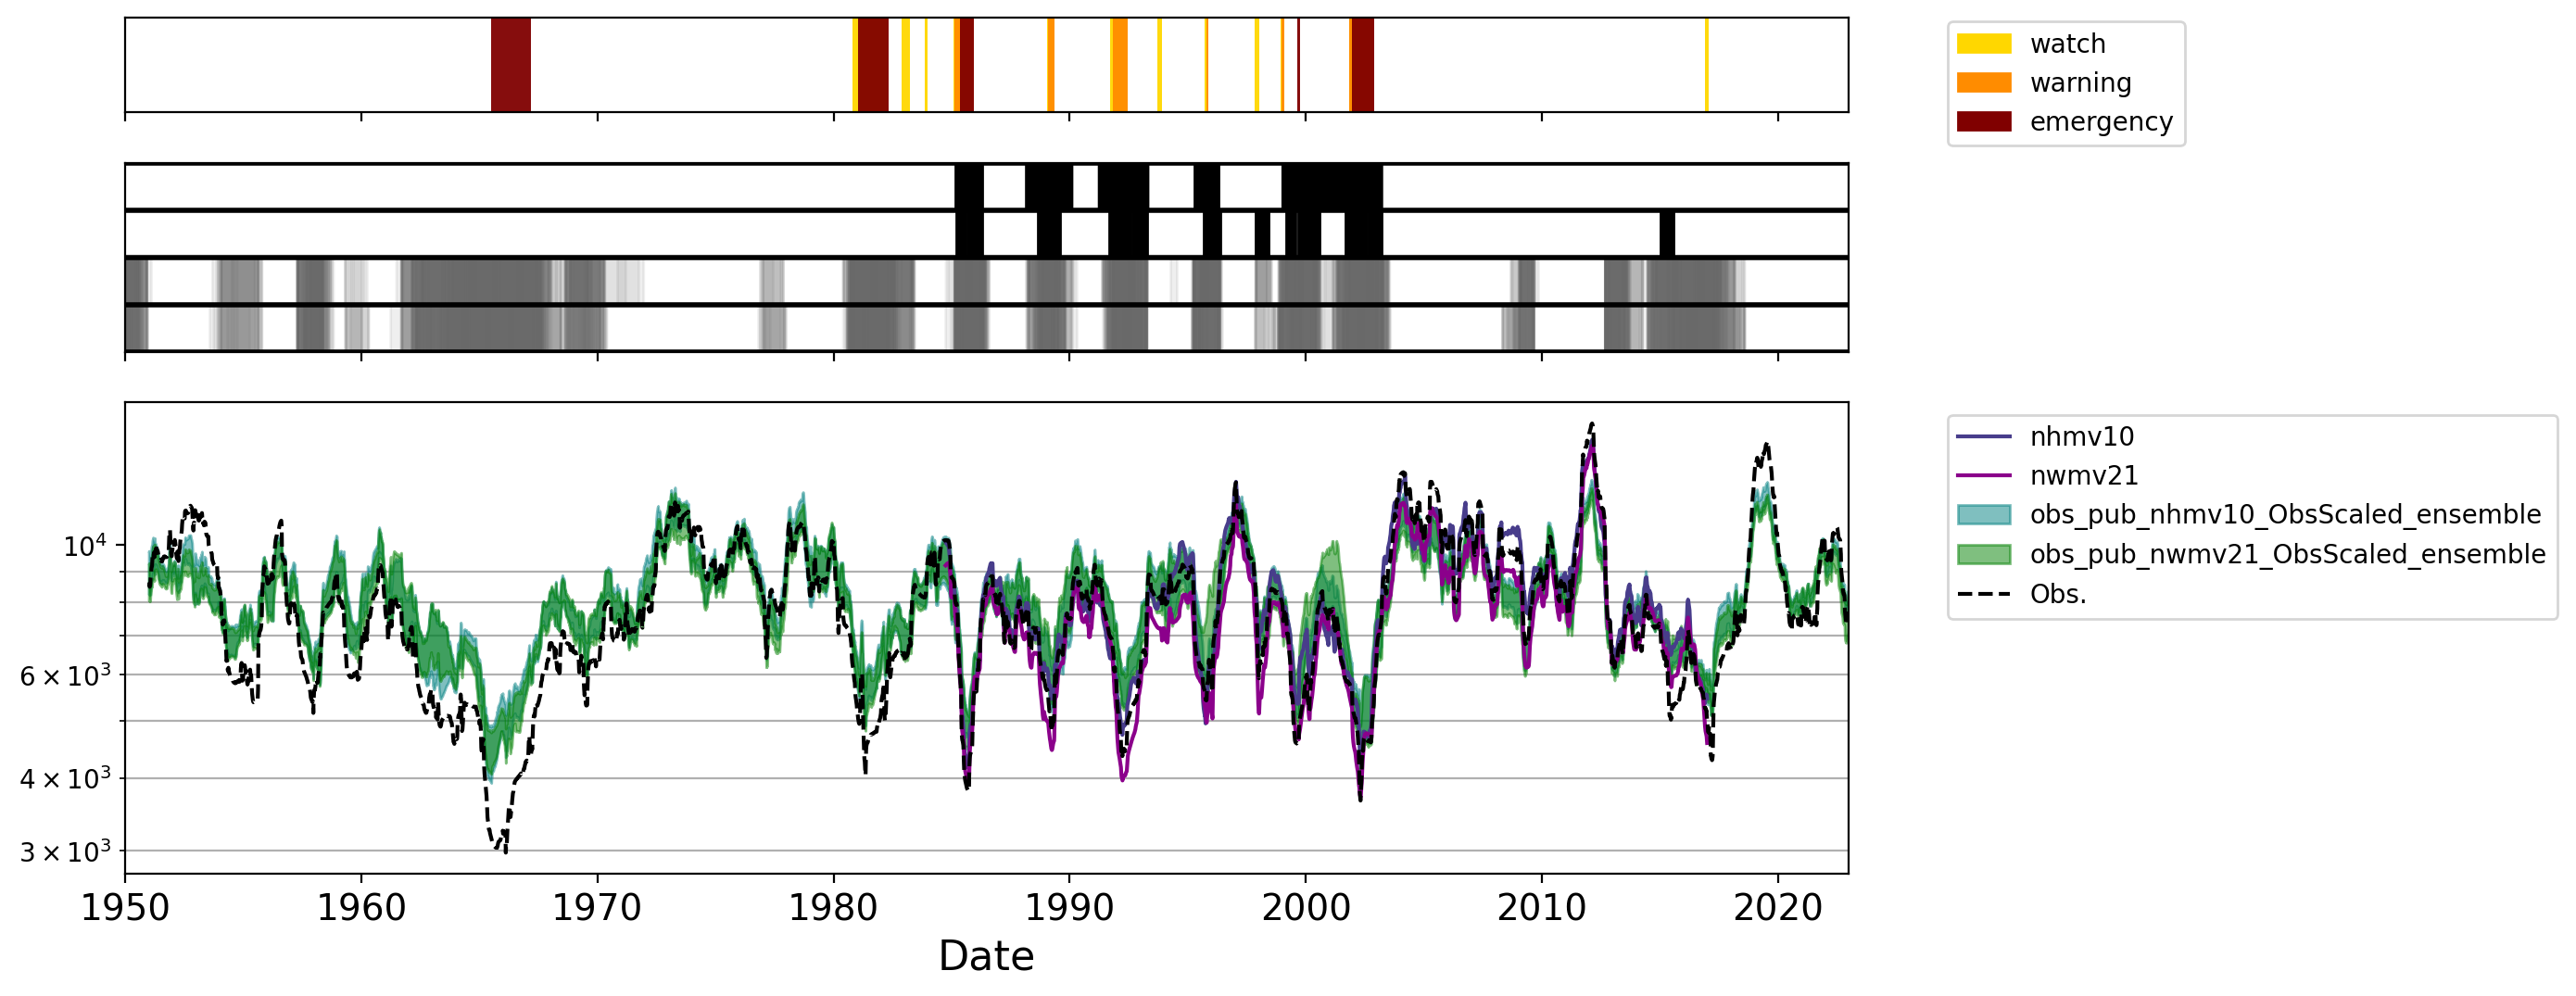

In [18]:
# Specifications
t_start='1950-01-01'
t_end='2022-12-31'
plot_nodes = ['delTrenton']
transform_type = 'rolling'
# transform_type = 'aggregation'
window = 365
aggregation_type = 'mean'
aggregation_length = 'M' #'M'

# Define colors for different event types
event_colors = {'watch': 'gold', 
                'warning': 'darkorange', 
                'emergency': 'maroon'}

# Create a figure with two subplots
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(12, 6), dpi=200,
                               sharex=True, gridspec_kw={'height_ratios': [1, 2,5]})

## DRBC-classified drought events
# Iterate through the events and create colored bars
for index, row in drbc_droughts.iterrows():
    color = event_colors[row['event_type']]
    start_date = pd.to_datetime(row['start_date'])
    end_date = pd.to_datetime(row['end_date'])
    ax1.axvspan(start_date, end_date, facecolor=color, edgecolor='none', alpha=0.95)

# Adding legend for the event types
handles = [mpatches.Patch(color=color, label=event_type) for event_type, color in event_colors.items()]
ax1.legend(handles=handles, loc='upper left', bbox_to_anchor=(1.05, 1.1))
# ax1.set_ylabel('DRBC\nDroughts', fontsize=14)
ax1.set_yticks([])

### SSI-based droughts
ssi_model_types = ['nhmv10', 'nwmv21', 
                   'obs_pub_nhmv10_ObsScaled_ensemble', 'obs_pub_nwmv21_ObsScaled_ensemble']
for i, m in enumerate(ssi_model_types):
    band_ymax= 1 - i / len(ssi_model_types)
    band_ymin = band_ymax - 1 / len(ssi_model_types)
    
    if i == 0:
        ax2.hlines(y=band_ymax, xmin=pd.to_datetime(t_start), xmax=pd.to_datetime(t_end),
                    color='k', lw=2)
    ax2.hlines(y=band_ymin, xmin=pd.to_datetime(t_start), xmax=pd.to_datetime(t_end),
                color='k', lw=2)
    
    if 'ensemble' in m:
        
        
        for i, real_i in enumerate(ssi_d[m].keys()):
            ssi_instance = ssi_d[m][real_i].loc[t_start:t_end, plot_nodes[0]]
            Q_instance = Q[m][real_i].loc[ssi_instance.index, plot_nodes[0]]
            
            plot_ssi_band(ssi_instance, 
                          band_ymax, band_ymin, ax=ax2, 
                          fill_color='dimgrey',
                          alpha = 0.1)
            
            if i == 0:
                ensemble_data = pd.DataFrame(Q_instance, columns=[i], 
                                            index=Q_instance.index)
            else:
                ensemble_data[i] = Q_instance
            
            ensemble_data = ensemble_data.dropna(axis=1)
        
        ensemble_data = transform_flow(ensemble_data, transform = transform_type,
                                       window=window, aggregation_type = aggregation_type,
                                       aggregation_length = aggregation_length)       
            
        # Plot flow 90 quantile
        ax3.fill_between(x=ensemble_data.index,
                        y1=ensemble_data.quantile(0.95, axis=1),
                        y2=ensemble_data.quantile(0.05, axis=1),
                        color=model_colors[m], alpha=0.5, 
                        interpolate=False, 
                        label = m, zorder=2)
                    

    else:
        plot_ssi_band(ssi_d[m].loc[t_start:t_end, plot_nodes[0]], 
                      band_ymax, band_ymin, ax=ax2, alpha =1,
                      fill_color = 'k')

        ## Plot FLow
        Q_mi = Q[m].loc[t_start:t_end, plot_nodes[0]]
        Q_mi = transform_flow(Q_mi, transform = transform_type,
                                window=window, aggregation_type = aggregation_type,
                                aggregation_length = aggregation_length)
           
           
        ax3.plot(Q_mi,
                 c = model_colors[m], label = m, 
                 lw=1.5, zorder = 5)

# Plot observed
Q_obs = Q['obs'].loc[t_start:t_end, plot_nodes[0]]
Q_obs = transform_flow(Q_obs, transform = transform_type,
                        window=window, aggregation_type = aggregation_type,
                        aggregation_length = aggregation_length)

ax3.plot(Q_obs,
         c = 'k', label = 'Obs.', lw=1.5, zorder = 10, ls = 'dashed')
  
ax3.set_yscale('log')
ax2.set_ylim([0,1])
ax2.set_yticklabels([])
ax2.set_yticks([])

# ax1.set_title(f'{plot_nodes[0]} Inflow')
ax3.grid(True, axis='y', which = 'minor', zorder=1)
ax3.legend(loc='upper left', bbox_to_anchor=(1.05, 1.))
plt.xlabel('Date', fontsize=16)
plt.xticks(fontsize=14)
plt.xlim(pd.to_datetime(t_start), pd.to_datetime(t_end))
# plt.ylabel(f'SSI-{int(window/29)}', fontsize=14)
fig.align_ylabels()
# ax2.legend()
plt.show()


In [10]:
t_end

'2022-12-31'

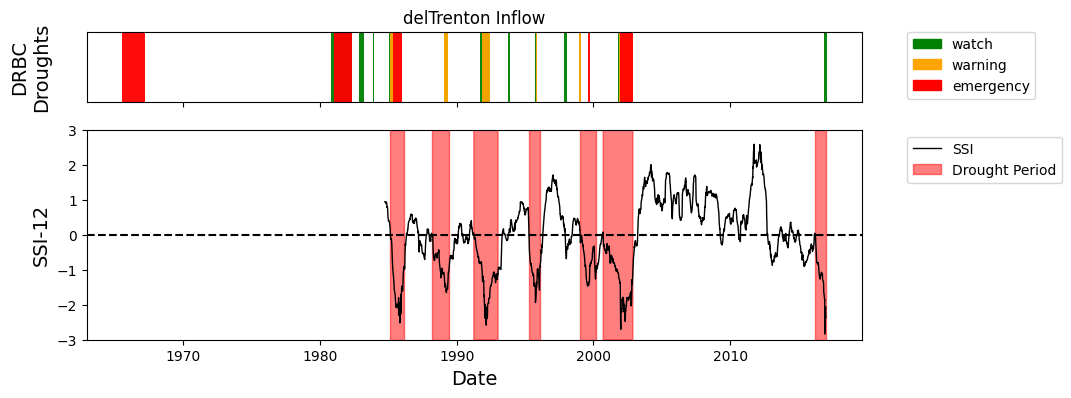

In [22]:
# Specifications
ssi = ssi_nhmv10
t_start='1960-01-01'
t_end='2022-12-31'

# Define colors for different event types
event_colors = {'watch': 'green', 
                'warning': 'orange', 
                'emergency': 'red'}
plot_nodes = ['delTrenton']


# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 4), 
                               sharex=True, gridspec_kw={'height_ratios': [1, 3]})

# Iterate through the events and create colored bars
for index, row in drbc_droughts.iterrows():
    color = event_colors[row['event_type']]
    start_date = pd.to_datetime(row['start_date'])
    end_date = pd.to_datetime(row['end_date'])
    ax1.axvspan(start_date, end_date, facecolor=color, edgecolor='none', alpha=0.95)

# Adding legend for the event types
handles = [mpatches.Patch(color=color, label=event_type) for event_type, color in event_colors.items()]
ax1.legend(handles=handles, loc='upper left', bbox_to_anchor=(1.05, 1.1))
ax1.set_ylabel('DRBC\nDroughts', fontsize=14)
ax1.set_yticks([])

# Your existing plot
plot_ssi(ssi.loc[t_start:t_end, plot_nodes[0]], ax=ax2)
ax1.set_title(f'{plot_nodes[0]} Inflow')

plt.xlabel('Date', fontsize=14)
plt.ylabel(f'SSI-{int(window/29)}', fontsize=14)
fig.align_ylabels()
ax2.legend(loc='upper left', bbox_to_anchor=(1.05, 1.))
plt.show()


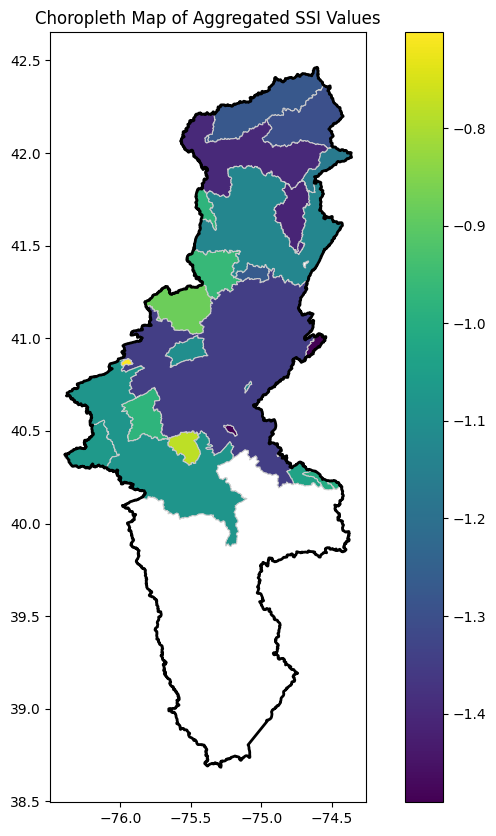

In [32]:
def plot_choropleth(node_basins, ssi, 
                    time_range=('1960-01-01', '2010-12-31'),
                    drb_boundary = None,
                    aggregation_method='mean'):
    aggregation_method_options = ['mean', 'min']
    
    # Aggregate the SSI values over the given time range
    ssi = ssi.loc[time_range[0]:time_range[1],:]
    if aggregation_method == 'mean':
        agg_ssi = ssi.mean().reset_index()
    elif aggregation_method == 'min':
        agg_ssi = ssi.min().reset_index()
    agg_ssi.columns = ['node', 'ssi']
    
    # Prepare a DataFrame for merging with node_basins
    merged = node_basins.merge(agg_ssi, on ='node')
    
    # Create the Choropleth figure
    fig, ax = plt.subplots(figsize=(10, 10))
    merged.plot(column='ssi', cmap='viridis', # vmax=0, vmin=-2, 
                linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
    if drb_boundary is not None:
        drb_boundary.plot(ax=ax, color='none', edgecolor='black', linewidth=2)

    plt.title('Choropleth Map of Aggregated SSI Values')
    plt.show()
    
    return

plot_choropleth(node_basins, ssi_nhmv10, drb_boundary=drb_boundary, time_range=('1985-02-22',	'1986-04-26'))

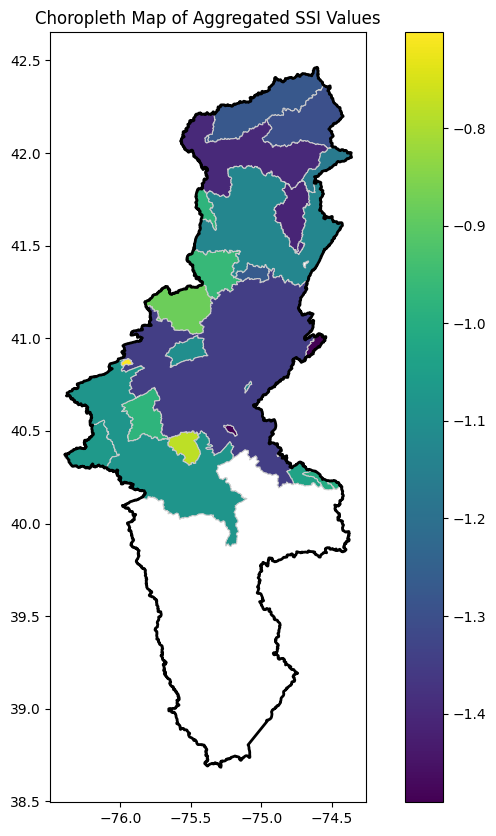

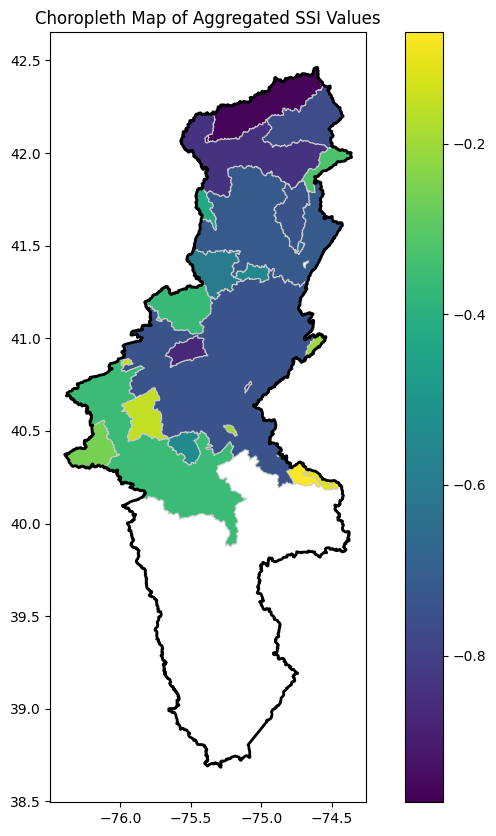

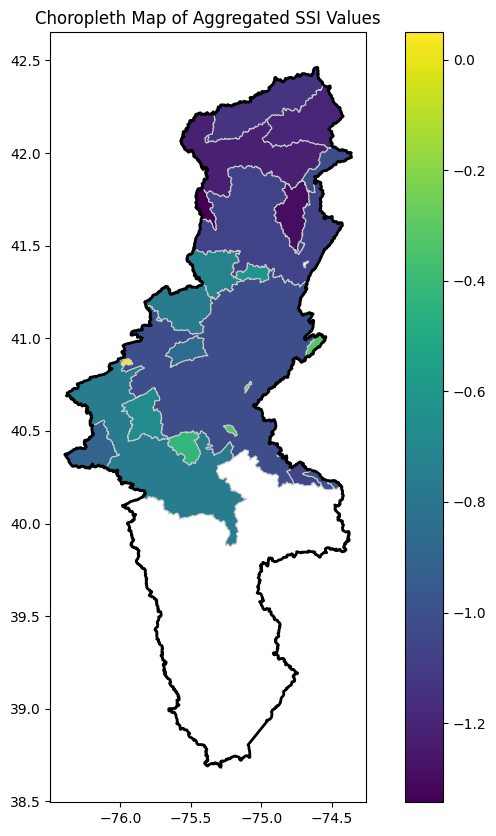

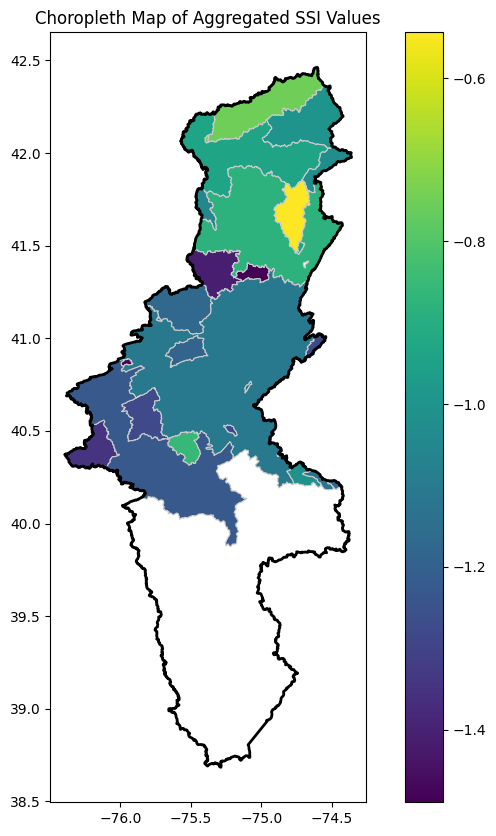

In [34]:
drought_metrics.loc[drought_metrics['node']=='delTrenton']


plot_choropleth(node_basins, ssi_nhmv10, drb_boundary=drb_boundary, time_range=('1985-02-22',	'1986-04-26'))

plot_choropleth(node_basins, ssi_nhmv10, drb_boundary=drb_boundary, time_range=('1988-03-01',	'1990-02-07'))
plot_choropleth(node_basins, ssi_nhmv10, drb_boundary=drb_boundary, time_range=('1995-04-14',	'1996-04-18'))
plot_choropleth(node_basins, ssi_nhmv10, drb_boundary=drb_boundary, time_range=('2000-09-17', '2003-03-24'))

In [23]:
plot_nodes = ['Total NYC', 'blueMarsh', 'beltzvilleCombined']
plot_nodes = nyc_reservoirs + upper_basin_reservoirs + mid_basin_reservoirs + lower_basin_reservoirs
ssi = ssi_nhmv10

drought_data = {}
drought_counter = 0
for node in ssi.columns:
    node_ssi = ssi[node]
    in_drought = False
    in_critical_drought = False

    drought_days = []

    for ind in range(len(ssi)):
        if node_ssi.values[ind] < 0:
            in_drought = True
            drought_days.append(ind)
            
            if node_ssi.values[ind] <= -1:
                in_critical_drought = True
        else:
            # Record drought info once it ends
            if in_critical_drought:
                drought_counter += 1
                drought_data[drought_counter] = {
                    'start':node_ssi.index[drought_days[0]],
                    'end': node_ssi.index[drought_days[-1]],
                    'duration': len(drought_days),
                    'magnitude': sum(node_ssi.values[drought_days]),
                    'severity': min(node_ssi.values[drought_days]),
                    'node': node
                }
                
            in_drought = False
            in_critical_drought = False
            drought_days = [] 

drought_metrics = pd.DataFrame(drought_data).transpose()

drought_metrics.head()


,start,end,duration,magnitude,severity,node
1,1984-12-15,1986-06-10,543,-560.993945,-2.17627,cannonsville
2,1988-03-01,1990-02-15,717,-684.680619,-2.258738,cannonsville
3,1991-05-25,1993-04-10,687,-461.469701,-1.452223,cannonsville
4,1995-04-07,1996-05-01,391,-424.811101,-2.233094,cannonsville
5,1999-01-05,2000-04-25,477,-259.571337,-1.442337,cannonsville


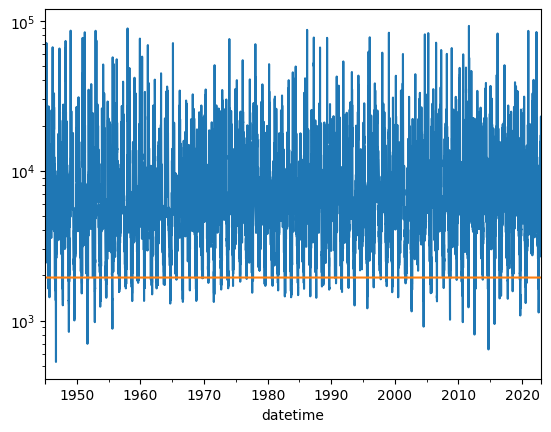

In [11]:
trenton_target = 3000*cfs_to_mgd

fig, ax = plt.subplots()
Q_hr['delTrenton'].plot(ax=ax)
ax.plot(Q_hr.index, np.ones_like(Q_hr['delTrenton'].values)*trenton_target)

ax.set_yscale('log')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


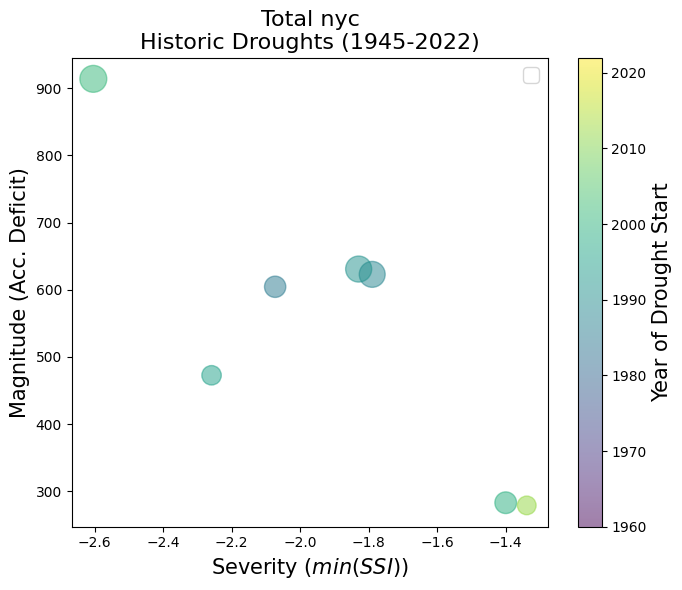

In [35]:
## Options
ssi = ssi_hr
marker_keys = {'NYC Reservoirs' : 'o',
               'Upper Basin Reservoirs' : "^",
               'Mid-Basin Reservoirs' : 'D',
               'Lower Basin Reservoirs': "v"}


highlight_after_1970 = False
color_by_metric = 'date'
size_by_metric = 'duration'
plot_nodes = ['Total NYC']

fig, ax = plt.subplots(figsize = (7,6))

# Loop through nodes
for node in plot_nodes:
    node_drought_metrics = drought_metrics[drought_metrics['node']==node]
    xs = node_drought_metrics['severity']
    ys = -node_drought_metrics['magnitude']

    if color_by_metric == 'duration':
        marker_colors = node_drought_metrics[color_by_metric]
    elif color_by_metric == 'date':
        marker_colors = pd.to_datetime(node_drought_metrics['start']).dt.year

    # Assign marker shape
    if node in nyc_reservoirs:
        marker_shape = marker_keys['NYC Reservoirs']
    elif node in upper_basin_reservoirs:
        marker_shape = marker_keys['Upper Basin Reservoirs']
    elif node in mid_basin_reservoirs:
        marker_shape = marker_keys['Mid-Basin Reservoirs']
    elif node in lower_basin_reservoirs:
        marker_shape = marker_keys['Lower Basin Reservoirs']
    else: 
        marker_shape = 'o'

    marker_sizes = node_drought_metrics[size_by_metric].values/2 if size_by_metric else 100
    marker_sizes = list(marker_sizes)

    p = ax.scatter(xs, ys,
                s = marker_sizes,
                marker=marker_shape,
                c=marker_colors, vmin=1960, vmax=2022, 
                alpha = 0.5)


if color_by_metric:
    plt.colorbar(p).set_label(label = 'Year of Drought Start',size=15)
plt.xlabel(r'Severity ($min(SSI)$)', fontsize = 15)
plt.ylabel(r'Magnitude (Acc. Deficit)', fontsize = 15)
if len(plot_nodes) == 1:
    plt.title(f'{plot_nodes[0].capitalize()}\nHistoric Droughts (1945-2022)', fontsize = 16)
else:
    plt.title(f'DRB Historic Droughts (1945-2022)', fontsize = 16)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()


,start,end,duration,magnitude,severity,node
176,1985-02-22,1986-04-26,429,-577.789688,-2.519233,delTrenton
177,1988-03-01,1990-02-07,709,-524.370664,-1.653691,delTrenton
178,1991-04-01,1993-04-28,759,-873.280963,-2.583012,delTrenton
179,1995-04-14,1996-04-18,371,-376.074084,-1.937838,delTrenton
180,1999-01-10,2000-08-18,587,-415.663919,-1.466071,delTrenton
181,2000-09-17,2003-03-24,919,-1018.862167,-2.70136,delTrenton
